### Let's demonstrate the image formation pipeline in ``cryojax``.

In [1]:
%reload_ext autoreload
%autoreload 2

# Jax imports
import equinox as eqx
import jax
import jax.numpy as jnp
import numpy as np
from jax import config

config.update("jax_enable_x64", False)
from cryojax.simulator.scattering._gaussian_mixture import _evaluate_coord_to_grid_sq_distances
from cryojax.simulator.scattering import _build_pixel_grid, IndependentAtomScattering
from cryojax.simulator.density import AtomCloud



In [2]:
# Plotting imports and function definitions
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [3]:
def plot_image(image, fig, ax, cmap="gray", **kwargs):
    im = ax.imshow(image, cmap=cmap, origin="lower", **kwargs)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im, cax=cax)
    return fig, ax

In [4]:
# Image simulator imports
import cryojax.simulator as cs
from cryojax.utils import fftn, irfftn, fftfreqs

In [73]:

pixel_size = 0.4
stdev_val = 1.0

weights = jnp.array([1.0, 0.6, 0.4, .2])
variances = (jnp.ones(4) * stdev_val)**2 * 10
identity = jnp.array([0, 1, 2, 3, 0, 1, 2, 3])

key = jax.random.PRNGKey(8675309)

coordinates = jnp.stack([jnp.arange(8), -jnp.arange(8), jnp.arange(8)]).T*2
print(coordinates)

scattering = IndependentAtomScattering((100, 100))

ac = AtomCloud(weights, coordinates, variances, identity)
img = ac.scatter(scattering,pixel_size)


[[  0   0   0]
 [  2  -2   2]
 [  4  -4   4]
 [  6  -6   6]
 [  8  -8   8]
 [ 10 -10  10]
 [ 12 -12  12]
 [ 14 -14  14]]
(8,) (8,) coords.shape
(100, 1)
(1, 100, 8) (100, 1, 8) disp shapes
(100, 100, 8) (8,)
inside egk
(100, 100, 8)
(8,)
after  egk (100, 100, 8)


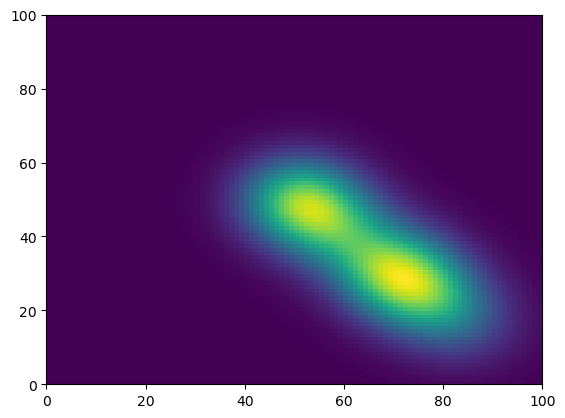

In [75]:

plt.pcolor(jnp.fft.ifft2(img).real)

In [76]:
resolution = 1.0

specimen = cs.Specimen(density=ac, resolution = 1)

# Initialize the image formation pipeline
pose = cs.EulerPose(offset_x=-50.0, offset_y=20.0, view_phi=-20, view_theta=100, view_psi=20)
optics = cs.CTFOptics(defocus_u=10000, defocus_v=10000, amplitude_contrast=.07)
ice = cs.GaussianIce(key=jax.random.PRNGKey(seed=0), variance=cs.Exp(amplitude=1.0, scale=1.0))
exposure = cs.UniformExposure(N=1e5, mu=0.0)
detector = cs.GaussianDetector(pixel_size=resolution, key=jax.random.PRNGKey(seed=1234), variance=cs.Constant(1.0))

In [77]:
# Compile the image formation pipeline into the PipelineState
state = cs.PipelineState(pose=pose, ice=ice, optics=optics, exposure=exposure, detector=detector)

Finally, we can initialize our imaging models. Models are included that render images in the exit plane of the specimen (``ScatteringImage``), in the detector plane (``OpticsImage``), and from the detector readout (``DetectorImage``).

In [78]:
# Image formation models
scattering_model = cs.ScatteringImage(scattering=scattering, specimen=specimen, state=state)
optics_model = cs.OpticsImage(scattering=scattering, specimen=specimen, state=state)
detector_model = cs.DetectorImage(scattering=scattering, specimen=specimen, state=state)

hello
coord shape (8, 3)
hello
(8,) (8,) coords.shape
(100, 1)
(1, 100, 8) (100, 1, 8) disp shapes
(100, 100, 8) (8,)
inside egk
(100, 100, 8)
(8,)
after  egk (100, 100, 8)
made scattering image


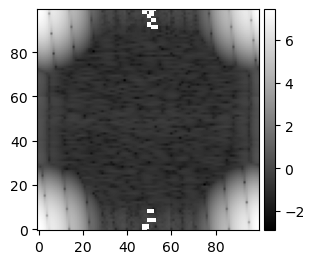

In [79]:
# Plot scattering in fourier space
fig, ax = plt.subplots(figsize=(3.25, 3.25))
im = plot_image(jnp.log10(jnp.abs(scattering_model.render(view=False))), fig, ax)
plt.tight_layout()

hello
coord shape (8, 3)
hello
(8,) (8,) coords.shape
(100, 1)
(1, 100, 8) (100, 1, 8) disp shapes
(100, 100, 8) (8,)
inside egk
(100, 100, 8)
(8,)
after  egk (100, 100, 8)
made scattering image
hello
coord shape (8, 3)
hello
(8,) (8,) coords.shape
(100, 1)
(1, 100, 8) (100, 1, 8) disp shapes
(100, 100, 8) (8,)
inside egk
(100, 100, 8)
(8,)
after  egk (100, 100, 8)
hello
coord shape (8, 3)
hello
(8,) (8,) coords.shape
(100, 1)
(1, 100, 8) (100, 1, 8) disp shapes
(100, 100, 8) (8,)
inside egk
(100, 100, 8)
(8,)
after  egk (100, 100, 8)


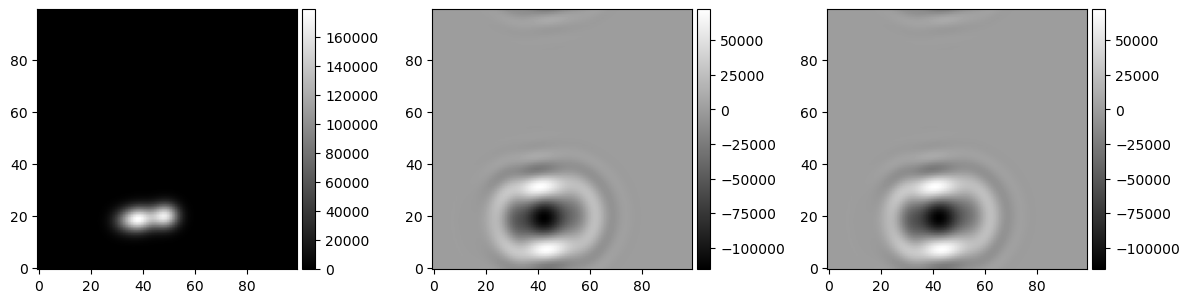

In [80]:
# Plot models
fig, axes = plt.subplots(ncols=3, figsize=(12, 6))
ax1, ax2, ax3 = axes
im1 = plot_image(scattering_model(), fig, ax1)
im2 = plot_image(optics_model(), fig, ax2)
im3 = plot_image(detector_model(), fig, ax3)
plt.tight_layout()

Models can also include ``Filter``s. The following is a demonstration of a ``WhiteningFilter`` and a ``LowpassFilter``. These are precomputed upon initialization and applied automatically in the image formation pipeline. 

To compute a ``WhiteningFilter``, we first have to generate some synthetic data of structured noise from which we may compute its power spectrum.

hello
coord shape (8, 3)
hello
(8,) (8,) coords.shape
(100, 1)
(1, 100, 8) (100, 1, 8) disp shapes
(100, 100, 8) (8,)
inside egk
(100, 100, 8)
(8,)
after  egk (100, 100, 8)


(<Figure size 350x350 with 2 Axes>, <Axes: >)

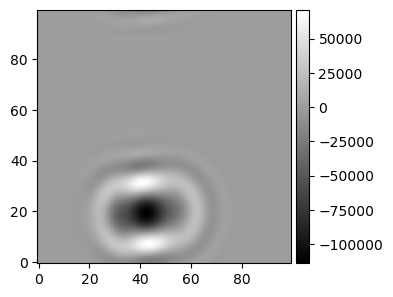

In [81]:
# Instantiate image filters
fig, ax = plt.subplots(figsize=(3.5, 3.5))
freqs = fftfreqs((800, 600), pixel_size=resolution)
micrograph = ice.sample(freqs) * optics(freqs) + fftn(detector.sample(freqs))
whiten = cs.WhiteningFilter(scattering.shape, micrograph=micrograph)
plot_image(irfftn(whiten(fftn(detector_model()))), fig, ax)

We see that the whitening filter looks right, empirically! Now generate an image with the toy icy structured noise model with a given whitening filter. We will also apply a whitening filter for antialiasing.

hello
coord shape (8, 3)
hello
(8,) (8,) coords.shape
(100, 1)
(1, 100, 8) (100, 1, 8) disp shapes
(100, 100, 8) (8,)
inside egk
(100, 100, 8)
(8,)
after  egk (100, 100, 8)


(<Figure size 350x350 with 2 Axes>, <Axes: >)

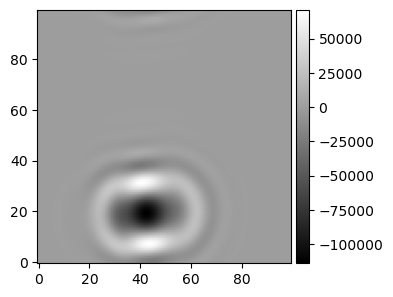

In [82]:
# Show forward model for a whitened image
fig, ax = plt.subplots(figsize=(3.5, 3.5))
filters = [cs.LowpassFilter(scattering.padded_shape, cutoff=0.95), cs.WhiteningFilter(scattering.padded_shape, micrograph=micrograph)]
filtered_model = cs.GaussianImage(scattering=scattering, specimen=specimen, state=state, filters=filters)
plot_image(filtered_model.render(), fig, ax)

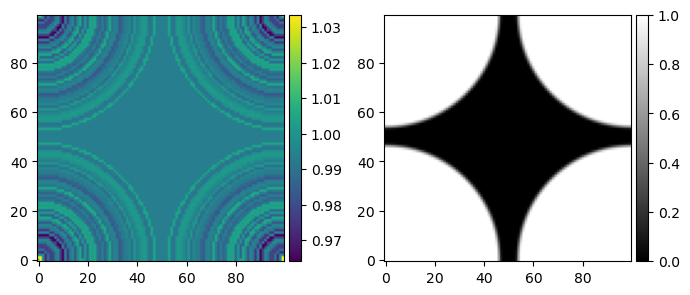

In [83]:
# Visualize filters
fig, axes = plt.subplots(ncols=2, figsize=(7, 5))
ax1, ax2 = axes
antialias, whiten = filters
im1 = plot_image(whiten.filter, fig, ax1, cmap="viridis")
im2 = plot_image(antialias.filter, fig, ax2, cmap="gray")
plt.tight_layout()

From all of the above, we see that computing an image is straight-forward. In practice, if we want to solve the inverse problem and find the model parameters that most likely generated the data, we want to define a function that can be arbitrarily transformed by JAX and evaulated at subsets of the parameters.

``Image`` models can take in these dictionaries, search over existing parameters, and update them in the underlying models in the ``PipelineState`` or ``Specimen``. This search introduces some python overhead, which can be optimized away with ``jax.jit``.

In [84]:
def build_pipeline(pixel_size: jax.Array) -> cs.GaussianImage:
    # Build the PipelineState
    d = eqx.tree_at(lambda d: d.pixel_size, detector, pixel_size)
    state = cs.PipelineState(
        pose=pose, optics=optics, detector=d, ice=ice, exposure=exposure
    )
    # Build the model
    model = cs.GaussianImage(
        scattering=scattering, specimen=specimen, state=state
    )
    return model

@jax.jit
def pipeline(pixel_size: jax.Array) -> jax.Array:
    model = build_pipeline(pixel_size)
    return model()

hello
coord shape (8, 3)
hello
(8,) (8,) coords.shape
(100, 1)
(1, 100, 8) (100, 1, 8) disp shapes
(100, 100, 8) (8,)
inside egk
(100, 100, 8)
(8,)
after  egk (100, 100, 8)


(<Figure size 800x600 with 4 Axes>, <Axes: >)

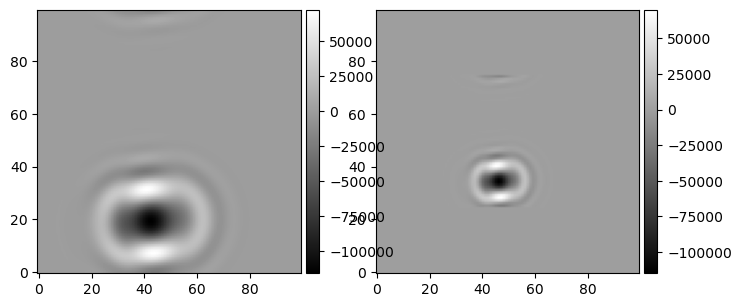

In [85]:
# Plot jitted model with updated parameters.
fig, axes = plt.subplots(ncols=2, figsize=(8, 6))
ax1, ax2 = axes
plot_image(pipeline(detector.pixel_size), fig, ax1)
plot_image(pipeline(2*detector.pixel_size), fig, ax2)

Now, we can also use the model to compute a likelihood. For this, we can use the ``GaussianImage`` model. This is a subclass of the ``DetectorImage``, adding the ability to evaulate a likelihood. Let's evaulate the likelihood at the simulated data, and visualize the residuals.

hello
coord shape (8, 3)
hello
(8,) (8,) coords.shape
(100, 1)
(1, 100, 8) (100, 1, 8) disp shapes
(100, 100, 8) (8,)
inside egk
(100, 100, 8)
(8,)
after  egk (100, 100, 8)
hello
coord shape (8, 3)
hello
(8,) (8,) coords.shape
(100, 1)
(1, 100, 8) (100, 1, 8) disp shapes
(100, 100, 8) (8,)
inside egk
(100, 100, 8)
(8,)
after  egk (100, 100, 8)
hello
coord shape (8, 3)
hello
(8,) (8,) coords.shape
(100, 1)
(1, 100, 8) (100, 1, 8) disp shapes
(100, 100, 8) (8,)
inside egk
(100, 100, 8)
(8,)
after  egk (100, 100, 8)


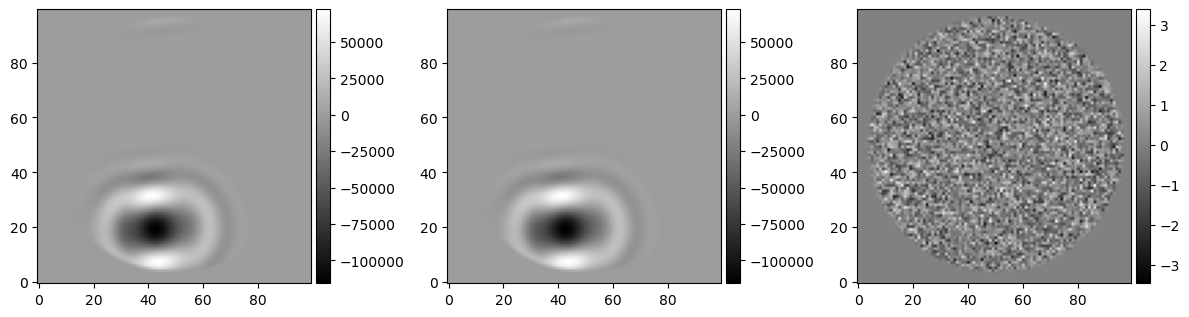

In [86]:
# Initialize the model and plot residuals
fig, axes = plt.subplots(ncols=3, figsize=(12, 6))
ax1, ax2, ax3 = axes
mask = cs.CircularMask(scattering.shape)
masks = [mask]
observation_model = cs.GaussianImage(scattering=scattering, specimen=specimen, state=state)
observed = mask(observation_model())
model = cs.GaussianImage(scattering=scattering, specimen=specimen, state=state, masks=masks, observed=observed)
simulated, observed, residuals = model.render(), model.observed, model.residuals
plot_image(simulated, fig, ax1)
plot_image(observed, fig, ax2)
plot_image(residuals, fig, ax3)
plt.tight_layout()

Evaluating the ``GaussianImage`` with the observed data set will automatically evaulate the ``GausianImage.log_likelihood`` function.

In [87]:
# Parameters on which to evaluate loss
params = dict(
    pixel_size=detector.pixel_size+0.01, offset_z=jnp.asarray(100.0)
)

In [88]:
def build_loss(params: dict[str, jax.Array]) -> cs.GaussianImage:
    # Build the PipelineState
    p = eqx.tree_at(lambda p: p.offset_z, pose, params["offset_z"])
    d = eqx.tree_at(lambda d: d.pixel_size, detector, params["pixel_size"])
    state = cs.PipelineState(
        pose=p, optics=optics, detector=d
    )
    # Build the model
    model = cs.GaussianImage(
        scattering=scattering, specimen=specimen, state=state, observed=observed
    )
    return model

@jax.jit
def loss(pixel_size: jax.Array) -> jax.Array:
    model = build_loss(pixel_size)
    return model()

@jax.jit
@jax.value_and_grad
def grad_loss(pixel_size: jax.Array) -> jax.Array:
    model = build_loss(pixel_size)
    return model()

In [89]:
# Benchmark loss pipeline
%timeit likelihood = loss(params)

hello
coord shape (8, 3)
hello
(8,) (8,) coords.shape
(100, 1)
(1, 100, 8) (100, 1, 8) disp shapes
(100, 100, 8) (8,)
inside egk
(100, 100, 8)
(8,)
after  egk (100, 100, 8)
59.6 µs ± 25.2 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [90]:
# Benchmark gradient pipeline
%timeit grad = grad_loss(params)

hello
coord shape (8, 3)
hello
(8,) (8,) coords.shape
(100, 1)
(1, 100, 8) (100, 1, 8) disp shapes
(100, 100, 8) (8,)
inside egk
(100, 100, 8)
(8,)
after  egk (100, 100, 8)
117 µs ± 40.1 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
